# XenonPy-iQSPR tutorial

This tutorial provides step by step guidance to all the essential components for running iQSPR, an inverse molecular design algorithm based on machine learning. We provide a set of in-house data and pre-trained models for demonstration purpose. We reserve all rights for using these resources outside of this tutorial. We recommend readers to have prior knowledge about python programming, use of numpy and pandas packages, building models with scikit-learn, and understanding on the fundamental functions of XenonPy (refer to the tutorial on the descriptor calculation and model building with XenonPy). For any question, please contact the developer of XenonPy. (v.0.4.1)

Overview - We are interested in finding molecular structures ùëÜ such that their properties ùëå have a high probability of falling into a target region ùëà, i.e., we want to sample from the posterior probability ùëù(ùëÜ|ùëå‚ààùëà) that is proportional to ùëù(ùëå‚ààùëà|ùëÜ)ùëù(ùëÜ) by the Bayes‚Äô theorem. ùëù(ùëå‚ààùëà|ùëÜ) is the likelihood function that can be derived from any machine learning models predicting ùëå for a given ùëÜ. ùëù(ùëÜ) is the prior that represents all possible candidates of S to be considered. iQSPR is a numerical implementation for this Bayesian formulation based on sequential Monte Carlo sampling, which requires a likelihood model and a prior model, to begin with.

This tutorial will proceed as follow:
1. initial setup and data preparation
2. descriptor preparation for forward model (likelihood)
3. forward model (likelihood) preparation
4. `NGram` (prior) preparation
5. a complete iQSPR run

In [1]:
import xenonpy
xenonpy.__version__

'0.4.1'

### Useful functions

First, we import some basic libraries and functions that are not directly related to the use of iQSPR. You may look into the "tools.ipynb" for the content. We also pre-set a numpy random seed for reproducibility. The same seed number is used throughout this tutorial.

In [2]:
%run tools.ipynb

np.random.seed(201906)


/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Data preparation (in-house data)

Here is a data set that contains 16674 SMILES randomly selected from pubchem with 2 material properties, the internal energy E (kJ/mol) and the HOMO-LUMO gap (eV). The property values are obtained from single-point calculations in DFT (density functional theory) simulations, with compounds geometry optimized at the B3LYP/6-31G(d) level of theory using GAMESS. This data set is prepared by our previous developers of iQSPR. XenonPy supports pandas dataframe as the main input source. When there are mismatch in the number of data points available in each material property, i.e., there exists missing values, please simply fill in the missing values with NaN, and XenonPy will automatically handle them during model training.

You can download the in-house data at https://github.com/yoshida-lab/XenonPy/releases/download/v0.4.1/iQSPR_sample_data.csv

In [3]:
# load in-house data
data = pd.read_csv("./iQSPR_sample_data.csv")

# take a look at the data
data.columns
data.head()

Unnamed: 0                            SMILES        E  HOMO-LUMO gap
0           1  CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C  177.577       4.352512
1           2     CC(=O)OC(CC(=O)O)C[N+](C)(C)C  185.735       7.513497
2           3          C1=CC(C(C(=C1)C(=O)O)O)O   98.605       4.581348
3           4                           CC(CN)O   83.445       8.034841
4           5              C(C(=O)COP(=O)(O)O)N   90.877       5.741310

Let us visualize some statistics of the data set. We can see that the mean character length of the SMILES is around 30. This roughly corresponds to around 20 tokens in iQSPR due to the way we combine some characters into a single token to be handled during the molecule modification step. Furthermore, the data shows a clear Pareto front at the high HOMO-LUMO gap region and the lack of molecules for HOMO-LUMO gap below 3. In this tutorial, we will try to populate the region of HOMO-LUMO gap less than 3 and internal energy less than 200.

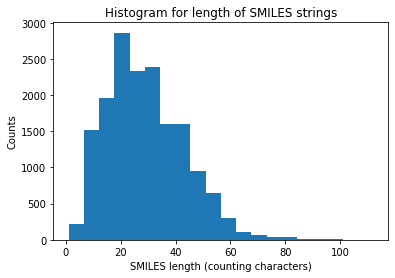

In [4]:
# check the SMILES length
count = [len(x) for x in data['SMILES']]
plt.hist(count, bins=20)  # arguments are passed to np.histogram
plt.title('Histogram for length of SMILES strings')
plt.xlabel('SMILES length (counting characters)')
plt.ylabel('Counts')
plt.show()


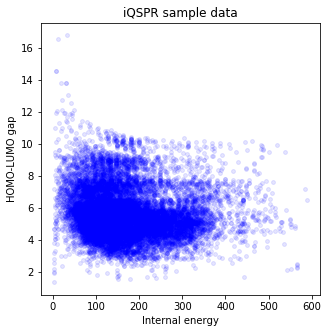

In [5]:
# check target properties: E & HOMO-LUMO gap
plt.figure(figsize=(5,5))
plt.scatter(data['E'],data['HOMO-LUMO gap'],s=15,c='b',alpha = 0.1)
plt.title('iQSPR sample data')
plt.xlabel('Internal energy')
plt.ylabel('HOMO-LUMO gap')
plt.show()


A complete iQSPR run may take a very long time. For practical purposes, the full design process can be separately done in multiple steps, and we recommend taking advantage of parallel computing if possible. To save time in this tutorial, we will extract only a subset of the full in-house data set for demonstration. You will see that the subset represents the full data set in our target property space well. Readers can try to repeat this tutorial with the full data set if sufficient computing resource is available.

   index  Unnamed: 0                               SMILES        E  \
0  16101       23630            CC(C)CN1CC(C1)C2=CC=CC=C2  193.542   
1  13275       19222               C1=CC(=CN=C1)C(=O)OCCO  110.998   
2  13879       20189  C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)CCCl  202.960   
3   5313        7775                    CCCCCC(=O)OCC(C)C  191.230   
4   8254       11881         C1=CC(=C(C=C1O)C(=O)O)C(=O)O   91.482   

   HOMO-LUMO gap  
0       5.914093  
1       5.186226  
2       5.400097  
3       7.727368  
4       4.856441  


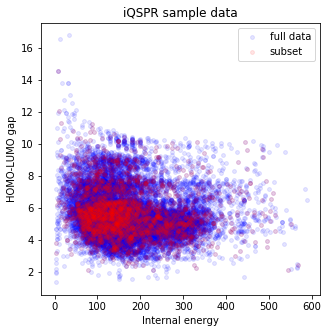

In [6]:
np.random.seed(201903) # fix the random seed

# extract a subset from the full data set
data_ss = data.sample(3000).reset_index()
print(data_ss.head())

# check target properties: E & HOMO-LUMO gap
plt.figure(figsize=(5,5))
plt.scatter(data['E'],data['HOMO-LUMO gap'],s=15,c='b',alpha = 0.1,label="full data")
plt.scatter(data_ss['E'],data_ss['HOMO-LUMO gap'],s=15,c='r',alpha = 0.1,label="subset")
plt.legend(loc='upper right')
plt.title('iQSPR sample data')
plt.xlabel('Internal energy')
plt.ylabel('HOMO-LUMO gap')
plt.show()

### Descriptor and forward model preparation

XenonPy provides out-of-the-box fingerprint calculators. We currently support all fingerprints and descriptors in the RDKit (Mordred will be added soon). In this tutorial, we only use the ECFP + MACCS in RDKit. You may combine as many descriptors as you need. We currently support `input_type` to be 'smiles' or 'mols' (the RDKit internal mol format) and some of the basic options in RDKit fingerprints. The output will be a pandas dataframe that is supported scikit-learn when building forward model with various machine learning methods.

In [7]:
from xenonpy.descriptor import Fingerprints

RDKit_FPs = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles')


To get the calculated fingerprints, simply use the transform function. The column names are pre-defined in XenonPy.

In [8]:
tmp_FPs = RDKit_FPs.transform(data_ss['SMILES'])
print(tmp_FPs.head())


   maccs:0  maccs:1  maccs:2  maccs:3  maccs:4  maccs:5  maccs:6  maccs:7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   maccs:8  maccs:9  ...  ecfp3:2038  ecfp3:2039  ecfp3:2040  ecfp3:2041  \
0        1        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   ecfp3:2042  ecfp3:2043  ecfp3:2044  ecfp3:2045  ecfp3:2046  ecfp3:2047  
0   

XenonPy also allows users to flexibly organize the desired descriptors. The first step is to import `BaseDescriptor` and all necessary descriptors (fingerprints) supported by XenonPy, which will be used to construct a customized set of descriptors for forward prediction. Then, users can simply pack all descriptors needed in the `BaseDescriptor`. For other descriptors, users can use the `BaseFeaturizer` class to construct for their own needs. If so, we would appreciate very much if you could share the code as a contribution to this project: https://github.com/yoshida-lab/XenonPy/tree/master/xenonpy/contrib. 

In [9]:
# XenonPy descriptor calculation library
from xenonpy.descriptor.base import BaseDescriptor
from xenonpy.descriptor import ECFP, MACCS


Defining your own `BaseDescriptor` allows you to customize the options for each fingerprint you wanted. You may combine multiple descriptors by adding more "self.XXX" in the `BaseDescriptor`. All descriptors with the same name "XXX" will be concatenated as one long descriptor. 

In [10]:
# prepare descriptor function from XenonPy (possible to combine multiple descriptors)
class RDKitDesc(BaseDescriptor):
    def __init__(self, n_jobs=-1, on_errors='nan'):
        super().__init__()
        self.n_jobs = n_jobs

        self.rdkit_fp = ECFP(n_jobs, on_errors=on_errors, input_type='smiles')
        self.rdkit_fp = MACCS(n_jobs, on_errors=on_errors, input_type='smiles')

ECFP_plus_MACCS = RDKitDesc()


In [11]:
tmp_FPs = ECFP_plus_MACCS.transform(data_ss['SMILES'])
print(tmp_FPs.head())


   ecfp3:0  ecfp3:1  ecfp3:2  ecfp3:3  ecfp3:4  ecfp3:5  ecfp3:6  ecfp3:7  \
0        0        1        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        1        0        0        0        0        0        0   
3        0        1        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   ecfp3:8  ecfp3:9  ...  maccs:157  maccs:158  maccs:159  maccs:160  \
0        0        0  ...          0          1          0          1   
1        0        0  ...          1          0          1          0   
2        0        0  ...          1          1          1          0   
3        0        0  ...          1          0          1          1   
4        0        0  ...          1          0          1          0   

   maccs:161  maccs:162  maccs:163  maccs:164  maccs:165  maccs:166  
0          1          1          1

##### train forward models inside XenonPy

**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

The prepared descriptor class will be added to the forward model class used in iQSPR. The forward model calculates the likelihood value for a given molecule. iQSPR provides a Gaussian likelihood template, but users can also write their own BaseLogLikelihood class. To prepare the Gaussian likelihood, iQSPR provides two options:
1. use the default setting - Bayesian linear model
2. use your own pre-trained model that output mean and standard deviation.

Here, we start with the first option. Note that there are a few ways to set the target region of the properties.

In [12]:
%%time

# Forward model template in XenonPy-iQSPR 
from xenonpy.inverse.iqspr import GaussianLogLikelihood

# write down list of property name(s) for forward models and decide the target region
# (they will be used as a key in whole iQSPR run)
prop = ['E','HOMO-LUMO gap']
target_range = {'E': (0,200), 'HOMO-LUMO gap': (-np.inf, 3)}

# import descriptor class to iQSPR and set the target of region of the properties
prd_mdls = GaussianLogLikelihood(descriptor=RDKit_FPs, targets = target_range)

# train forward models inside iQSPR
prd_mdls.fit(data_ss['SMILES'], data_ss[prop])

# target region can also be updated afterward
prd_mdls.update_targets(reset=True,**target_range)


CPU times: user 1min 21s, sys: 2.29 s, total: 1min 23s
Wall time: 1min 2s


The variable directly contains models for each property trained this way. Note that the input of these models is the preset descriptor (RDKit_FPs in this case).

In [13]:
prd_mdls['E']

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

The variable can be also used for prediction directly from mol/smiles, where the output is a dataframe.

In [14]:
%%time

pred = prd_mdls.predict(data_ss['SMILES'])
print(pred.head())

      E: mean     E: std  HOMO-LUMO gap: mean  HOMO-LUMO gap: std
0  216.509826  30.797906             6.447289            0.665743
1  149.129376  30.668275             5.067788            0.663043
2  196.939862  29.519475             5.394701            0.642767
3  223.707730  29.193235             7.786168            0.635042
4   87.583524  30.042102             4.707544            0.649219
CPU times: user 4.99 s, sys: 388 ms, total: 5.38 s
Wall time: 8.73 s


Let us take a look at the distribution of the likelihood values for all the molecules in our data as a validation. Note that directly calling the object is equivalent to calling the `log_likelihood` function. The output will be a pandas dataframe with properties on the columns. To get the final log-likelihood, you can simply sum over the columns. You will see that all molecules have a small likelihood because they are far from our target region. Note that when setting the target region for the likelihood calculation, "np.inf" is supported. Also, we use only log-likelihood in iQSPR to avoid numerial issue.

Note that we can also update the target region when calling the `log_likelihood` function, but this will automatically overwrite the existing target region!

In [15]:
%%time

# calculate log-likelihood for a given target property region
tmp_ll = prd_mdls(data_ss['SMILES'], **target_range)
print(tmp_ll.head())

          E  HOMO-LUMO gap
0 -1.217547     -16.004130
1 -0.049805      -7.003767
2 -0.613814      -9.236479
3 -1.568449     -31.357115
4 -0.001869      -5.456765
CPU times: user 5.12 s, sys: 396 ms, total: 5.51 s
Wall time: 9.29 s


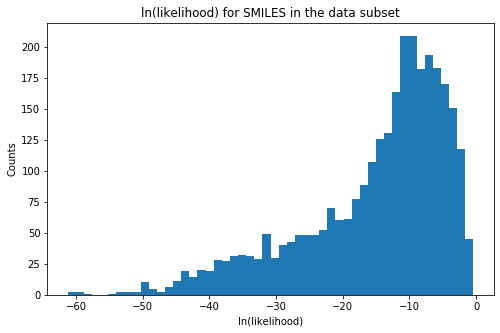

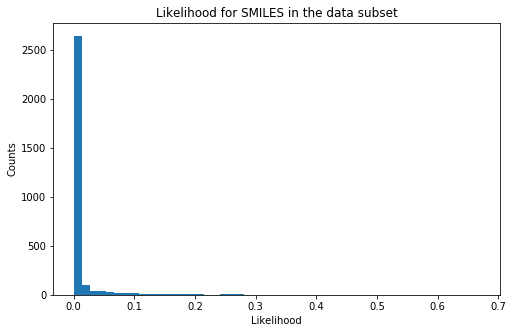

In [16]:
# plot histogram of log-likelihood values
tmp = tmp_ll.sum(axis = 1, skipna = True)

plt.figure(figsize=(8,5))
plt.hist(tmp, bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()


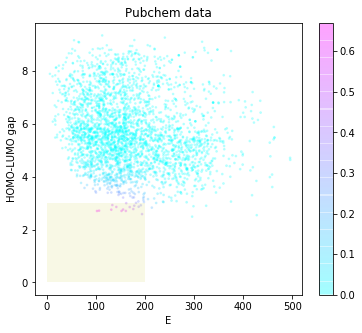

In [17]:
# check the predicted likelihood
dot_scale = 0.1
l_std = np.sqrt(pred['E: std']**2+pred['HOMO-LUMO gap: std']**2)

plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((0,0),200,3,fc='y',alpha=0.1)
plt.gca().add_patch(rectangle)
im = plt.scatter(pred['E: mean'], pred['HOMO-LUMO gap: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
plt.title('Pubchem data')
plt.xlabel('E')
plt.ylabel('HOMO-LUMO gap')
plt.colorbar(im)
plt.show()

**<span style="color: red; ">Warning: the next module may take 5-10min to complete!</span>**

The second option is to prepare your own forward model. In fact, this may often be the case because you may want to first validate your model before using it. When the training takes a long time, you want to avoid repeating the calculation that is simply wasting computing resources. In this tutorial, we will use gradient boosting. Let us first verify the performance of the model on our data set using a 10-fold cross-validation.

In [18]:
%%time

# forward model library from scikit-learn
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.linear_model import ElasticNet
# xenonpy library for data splitting (cross-validation)
from xenonpy.datatools import Splitter

np.random.seed(201906)

# property name will be used as a reference for calling models
prop = ['E','HOMO-LUMO gap']

# prepare indices for cross-validation data sets
sp = Splitter(data_ss.shape[0], test_size=0, k_fold=10)

# initialize output variables
y_trues, y_preds = [[] for i in range(len(prop))], [[] for i in range(len(prop))]
y_trues_fit, y_preds_fit = [[] for i in range(len(prop))], [[] for i in range(len(prop))]
mdls = {key: [] for key in prop}

# cross-validation test
for iTr, iTe in sp.cv():
    x_train = data_ss['SMILES'].iloc[iTr]
    x_test = data_ss['SMILES'].iloc[iTe]
    
    fps_train = RDKit_FPs.transform(x_train)
    fps_test = RDKit_FPs.transform(x_test)
    
    y_train = data_ss[prop].iloc[iTr]
    y_test = data_ss[prop].iloc[iTe]
    for i in range(len(prop)):
        #mdl = RandomForestRegressor(500, n_jobs=-1, max_features='sqrt')
        #mdl = ElasticNetCV(cv=5)
        mdl = GradientBoostingRegressor(loss='ls')
        #mdl = ElasticNet(alpha=0.5)
        
        mdl.fit(fps_train, y_train.iloc[:,i])
        prd_train = mdl.predict(fps_train)
        prd_test = mdl.predict(fps_test)

        y_trues[i].append(y_test.iloc[:,i].values)
        y_trues_fit[i].append(y_train.iloc[:,i].values)
        y_preds[i].append(prd_test)
        y_preds_fit[i].append(prd_train)

        mdls[prop[i]].append(mdl)


CPU times: user 5min 12s, sys: 7.06 s, total: 5min 19s
Wall time: 7min 13s


You will see that the performance is not so bad, especially inside the target region that we are aiming at.

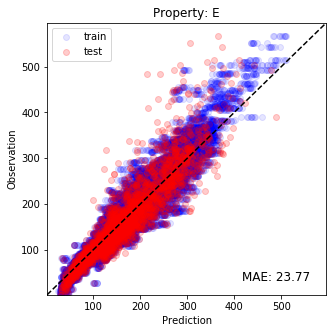

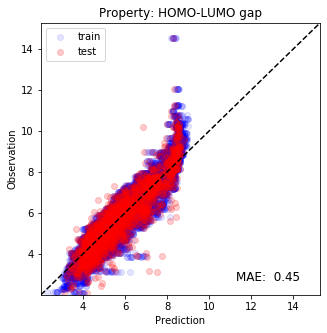

In [19]:
# plot results
for i, x in enumerate(prop):
    y_true = np.concatenate(y_trues[i])
    y_pred = np.concatenate(y_preds[i])
    y_true_fit = np.concatenate(y_trues_fit[i])
    y_pred_fit = np.concatenate(y_preds_fit[i])
    xy_min = min(np.concatenate([y_true,y_true_fit,y_pred,y_pred_fit]))*0.95
    xy_max = max(np.concatenate([y_true,y_true_fit,y_pred,y_pred_fit]))*1.05
    xy_diff = xy_max - xy_min
    
    plt.figure(figsize=(5,5))
    plt.scatter(y_pred_fit, y_true_fit, c='b', alpha=0.1, label='train')
    plt.scatter(y_pred, y_true, c='r', alpha=0.2, label='test')
    plt.text(xy_min+xy_diff*0.7,xy_min+xy_diff*0.05,'MAE: %5.2f' % np.mean(np.abs(y_true - y_pred)),fontsize=12)
    plt.title('Property: ' + x)
    plt.xlim(xy_min,xy_max)
    plt.ylim(xy_min,xy_max)
    plt.legend(loc='upper left')
    plt.xlabel('Prediction')
    plt.ylabel('Observation')
    plt.plot([xy_min,xy_max],[xy_min,xy_max],ls="--",c='k')
    plt.show()


Here, we define a class that return mean and std based on a list of models.
Note that the class must have a function called "predict" that takes a descriptor input and return first mean, then standard deviation. Here, we add a constant noise variance to the model variable calculated from the bootstrapped models.


In [20]:
class bootstrap_fcn():
    def __init__(self, ms, var):
        self.Ms = ms
        self.Var = var
    def predict(self, x):
        val = np.array([m.predict(x) for m in self.Ms])
        return np.mean(val, axis = 0), np.sqrt(np.var(val, axis = 0) + self.Var)
    
# include basic measurement noise
c_var = {'E': 650,'HOMO-LUMO gap': 0.5}

# generate a dictionary for the final models used to create the likelihood
custom_mdls = {key: bootstrap_fcn(value, c_var[key]) for key, value in mdls.items()}
    
# import descriptor calculator and forward model to iQSPR
prd_mdls = GaussianLogLikelihood(descriptor=RDKit_FPs, targets=target_range, **custom_mdls)


Once again, we can make predictions and calculate the likelihood values for the full data set.

      E: mean     E: std  HOMO-LUMO gap: mean  HOMO-LUMO gap: std
0  196.994309  26.048981             5.870756            0.707775
1  124.152421  25.704305             5.461278            0.708236
2  199.372752  26.200495             5.273028            0.707450
3  222.825184  25.863771             7.533414            0.707730
4   84.651376  25.595545             5.201233            0.708923


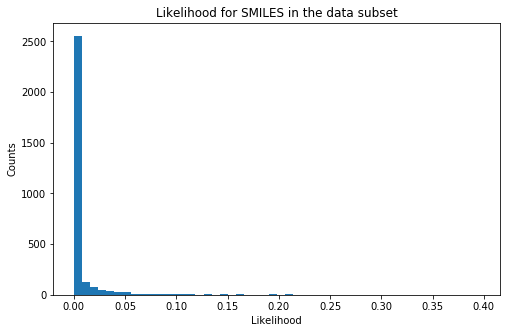

CPU times: user 8.3 s, sys: 894 ms, total: 9.19 s
Wall time: 24.4 s


In [21]:
%%time

pred = prd_mdls.predict(data_ss['SMILES'])
print(pred.head())

# calculate log-likelihood for a given target property region
tmp_ll = prd_mdls.log_likelihood(data_ss['SMILES'])
tmp = tmp_ll.sum(axis = 1, skipna = True)

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()

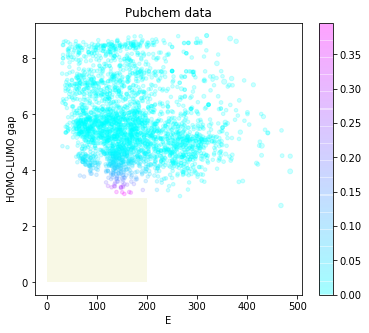

In [22]:
# check the predicted likelihood
dot_scale = 0.5
l_std = np.sqrt(pred['E: std']**2+pred['HOMO-LUMO gap: std']**2)

plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((0,0),200,3,fc='y',alpha=0.1)
plt.gca().add_patch(rectangle)
im = plt.scatter(pred['E: mean'], pred['HOMO-LUMO gap: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
plt.title('Pubchem data')
plt.xlabel('E')
plt.ylabel('HOMO-LUMO gap')
plt.colorbar(im)
plt.show()

**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

Use of multiple likelihood models is also supported. It is unnecessary in this example, but we will demonstrate how to do it by naively creating separate models for the two properties. Note that you can assign different descriptors to different likelihood models.

By creating your own `BaseLogLikelihoodSet` object, you can combine likelihood models as you need. However, make sure you setup the models before hand, including training of the models and setting up the target regions.

In [23]:
%%time

from xenonpy.inverse.base import BaseLogLikelihoodSet

prd_mdl1 = GaussianLogLikelihood(descriptor = RDKit_FPs, targets = {'E': (0, 200)})
prd_mdl2 = GaussianLogLikelihood(descriptor = ECFP_plus_MACCS, targets = {'HOMO-LUMO gap': (-np.inf, 3)})

prd_mdl1.fit(data_ss['SMILES'], data_ss['E'])
prd_mdl2.fit(data_ss['SMILES'], data_ss['HOMO-LUMO gap'])

class MyLogLikelihood(BaseLogLikelihoodSet):
    def __init__(self):
        super().__init__()
        
        self.loglike = prd_mdl1
        self.loglike = prd_mdl2
        
like_mdl = MyLogLikelihood()

CPU times: user 1min 7s, sys: 2.14 s, total: 1min 10s
Wall time: 54.7 s


Calculating likelihood values is the same as before, but `BaseLogLikelihoodSet` does not support direct prediction of the properties unless users define one themselves.

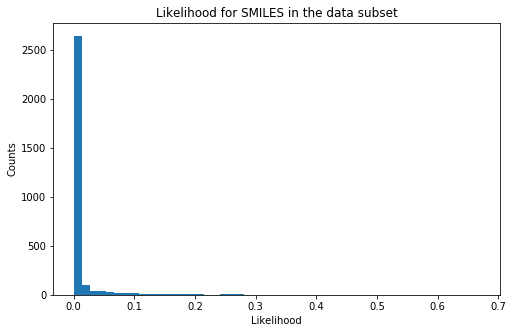

CPU times: user 8.03 s, sys: 804 ms, total: 8.83 s
Wall time: 20.9 s


In [24]:
%%time

# calculate log-likelihood for a given target property region
tmp_ll = like_mdl(data_ss['SMILES'])
tmp = tmp_ll.sum(axis = 1, skipna = True)

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()

### N-gram preparation

**<span style="color: red; ">Warning: the next module may take 3-5min to complete!</span>**

For prior, which is simply a molecule generator, we currently provide a N-gram model based on the extended SMILES language developed by our previous iQSPR developers. 

Note that because the default sample_order in `NGram` is 10, setting train_order=5 (max order to be used in iQSPR) when fitting will cause a warning, and XenonPy will automatically set sample_order=5 (actual order to be used when running the iQSPR).

There is a default lower bound to the train_order and sample_order = 1, representing to use at least one character as a reference for generating the next character. We do not recommend altering this number.

In [25]:
%%time

# N-gram library in XenonPy-iQSPR
from xenonpy.inverse.iqspr import NGram

# initialize a new n-gram
n_gram = NGram()

# train the n-gram with SMILES of available molecules
n_gram.fit(data_ss['SMILES'],train_order=5)


/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:119: RuntimeWarning: max <sample_order>: 10 is greater than max <train_order>: 5,max <sample_order> will be reduced to max <train_order>
  RuntimeWarning)
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3000/3000 [03:16<00:00, 15.26it/s]

CPU times: user 2min 52s, sys: 3.32 s, total: 2min 55s
Wall time: 3min 16s


NGram(del_range=(1, 10), max_len=1000, min_len=1, ngram_tab=None,
      reorder_prob=0, sample_order=(1, 5))

Let us take a look at the molecules generated by our trained N-gram.

In [26]:
np.random.seed(201903) # fix the random seed

# perform pure iQSPR molecule generation starting with 5 initial molecules
n_loop = 5
tmp = data_ss['SMILES'][:5]
for i in range(n_loop):
    tmp = n_gram.proposal(tmp)
    print('Round %i' % i,tmp)
    

Round 0 ['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)S', 'C1=CC(=CC=C1CC(C(=O)O)N)Cl', 'CCCCCC(=O)OCC1=CC=C(C=C1)O', 'C1=CC(=C(C=C1O)C(=O)O)[N+](=O)[O-]']
Round 1 ['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)Cl', 'C1=CC(=CC=C1CCCC(=O)O)OC', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)(=O)O', 'C1=CC(=C(C=C1O)C(=O)O)CCO']
Round 2 ['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C1=CC(=CC(=C1)OC)O', 'C1=CC(=CC=C1CCCC(=O)O)C(=O)C', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)C1=CC(=CC=C1NC(=O)C(CCCC1C(C(C1)O)O)N=C(N)N)O', 'C1=CC(=C(C=C1O)C(=O)O)CCN']
Round 3 ['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C1=CC(=CC=C1)Cl', 'C1=CC(=CC=C1CCCC(=O)O)Cl', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)C1=CC(=CC=C1NC(=O)C(CCCC1C(C(C1)O)O)N)OCC(CO)N', 'C1=CC(=C(C=C1O)O)N']
Round 4 ['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C#N', 'C1=CC(=CC=C1CCCCCC(=O)C(C1=CC=CC2=CC=CC=C2CCC2=CC=C(C=C2)Cl)NC(=N1)NCCCOC)C', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)

Our N-gram-based molecular generator runs as follow:
1. given a tokenized SMILES in the extended SMILES format, randomly delete N tokens from the tail,
2. generate the next token using the N-gram table until we hit a termination token or a pre-set maximum length,
3. if generation ended without a termination token, a simple gramma check will be performed trying to fix any invalid parts, and the generated molecule will be abandoned if this step fails. 

Because we always start the modification from the tail and SMILES is not a 1-to-1 representation of a molecule, we recommend users to use the re-order function to randomly re-order the extended SMILES, so that you will not keep modifying the same part of the molecule. To do so, you can use the "set_params" function or do so when you initialize the N-gram using "NGram(...)". In fact, you can adjust other parameters in our N-gram model this way.

Note that we did not re-order the SMILES when training our N-gram model, it is highly possible that a re-ordered SMILES during the generation process will lead to substrings that cannot be found in the pre-trained N-gram table, causing a warning message and the molecule will be kept the same.

In [27]:
# change internal parameters of n_gram generator
n_gram.set_params(del_range=[1,10],max_len=500, reorder_prob=0.5)

np.random.seed(201906) # fix the random seed

# perform pure iQSPR molecule generation starting with 10 PG molecules
n_loop = 5
tmp = data_ss['SMILES'][:5]
for i in range(n_loop):
    tmp = n_gram.proposal(tmp)
    print('Round %i' % i,tmp)
    

/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:404: RuntimeWarning: get_prob: ['C', '(', '=O', ')', '(', 'O', ')', 'c', '&', 'c', 'c'] not found in NGram, iB=0, iR=1
  warnings.warn('get_prob: %s not found in NGram, iB=%i, iR=%i' % (tmp_str, iB, iR), RuntimeWarning)


Round 0 ['CC(C)CN1CC(C1)C1(CCN(CC1)C)C1=CNC2=C1C=C(C=C2)Br', 'C1=CC(=CN=C1)C(=O)OCCO', 'C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)C(=O)CN1CCN(C1)C1=CC(=C(C(=C1)Cl)N=NC1=C(C=CC(=C1Cl)C)OC)N', 'O=C(CCCCC)Cl', 'C1=CC(=C(C=C1O)C(=O)O)O']
Round 1 ['C1C(C2(c3c[nH]c4ccc(Br)cc34)CCN(C)CC2)CCC2=CC(=O)N2C1', 'C1=CC(=CN=C1)C(=O)OCCO', 'C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)C(=O)CN1CCN(C1)C1=CC(=C(C(=C1)Cl)N=NC1=C(C=CC(=C1Cl)C)OCC1=CC=CS1)O', 'O=C(C(=O)O)S', 'C1=CC(=C(C=C1O)C(C(=O)O)O)Cl']


/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:404: RuntimeWarning: get_prob: ['C', '(', 'O', ')', 'C', 'O', 'C', '(', '=O', ')', 'c'] not found in NGram, iB=0, iR=0
  warnings.warn('get_prob: %s not found in NGram, iB=%i, iR=%i' % (tmp_str, iB, iR), RuntimeWarning)


Round 2 ['C1C(C2(c3c[nH]c4ccc(Br)cc34)CCN(C)CC2)CCC2=CC(=O)N2C1', 'C1=CC(=CN=C1)C(=O)OC1=CC(=CC(=C1C)C(=O)O)C(=O)OCCCCCCCBr', 'C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)C(=O)CN1CCN(C1)C1=CC(=C(C(=C1)Cl)N=NC1=C(C=CC(=C1Cl)C)OCC1=CC=CC=C1)N', 'O=C(CCl)N1CCCCCOCCCCOCCCCOC(C(O1)OCC1=CC=CC=C1)COC(=O)C(=C)C(=O)OCCN(C)CC1=CNC2=CC=CC=C12', 'C1=CC(=C(C=C1O)C(C(=O)O)NC(C)C)C(=O)OC1=CC(=C(C=C1)Cl)O']
Round 3 ['C1C(C2(c3c[nH]c4ccc(Br)cc34)CCN(C)CC2)CCC2=CC(=O)N2C1', 'C1=CC(=CN=C1)C(=O)OC1=CC(=CC(=C1C)C(=O)O)C(=O)OCCCCF', 'C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)C(=O)CN1CCN(C1)C1=CC(=C(C(=C1)Cl)N=NC1=C(C=CC(=C1Cl)C)OCCN(CC)C)Cl', 'O=C(CCl)N1CCCCCOCCCCOCCCCOC(C(O1)OCC1=CC=CC=C1)COC(=O)C(=C)C(=O)OCCN(C)CC1=CNC2=C1C(=O)N2', 'C1=CC(=C(C=C1O)C(C(=O)O)NC(C)C)C(=O)OC1=CC(=C(C=C1)Cl)O']
Round 4 ['C1C(C2(c3c[nH]c4ccc(Br)cc34)CCN(C)CC2)CCC2=CC(=O)N2C1', 'C1=CC(=CN=C1)C(=O)OC1=CC(=CC(=C1C)C(=O)O)C(=O)OCCCC', 'c1(Cl)c(C)ccc(OCCN(C)CC)c1N=Nc1c(Cl)cc(N2CCN(CC(=O)N(CCCl)c3ccc(CC(N)C(=O)O)cc3)C)OC1C(C=C2)CCCCCC', 'O=C(CCl)N1CCCCCOCCC

/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert CC(C)NC(C(=O)O)c1cc(O)ccc1C(=O)Oc1ccc(O1)(CC1=CNC2=C1C=CC(=C2O)O)CC to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)


To avoid getting stuck at certain molecule structures due to the re-ordering issue, we recommend two solutions: 

1. Avoid re-ordering: standardize the SMILES to a single format and avoid re-ordering during generation process. To avoid not modifying only certain part of the molecule, pick a larger maximum number for "del_range". This way, you will save time on training the N-gram model, but probably need more iteration steps during the actual iQSPR run for convergence to your target property region. This is recommend only if you are really out of computing power for training a big N-gram table.

2. Data augmentation: expand your training set of SMILES by adding re-ordered SMILES of each originally available SMILES. Be careful of the bias to larger molecules due to more re-order patterns for longer SMILES. This way, you will need longer time to train the N-gram model, but probably converge faster in the actual iQSPR run.

**<span style="color: red; ">Warning: the next module may take 5-10min to complete!</span>**

You can skip this part and proceed forward

In [41]:
%%time

# Method 1: use canonical SMILES in RDKit with no reordering
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in data_ss['SMILES']]
n_gram_cans = NGram(reorder_prob=0)
n_gram_cans.fit(cans)

# save results
with open('ngram_cans.obj', 'wb') as f:
    pk.dump(n_gram_cans, f)
    

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3000/3000 [04:13<00:00, 11.83it/s]

CPU times: user 4min 13s, sys: 1.44 s, total: 4min 14s
Wall time: 4min 14s


**<span style="color: red; ">Warning: the next TWO modules may take 5-6hr to complete!</span>**

You can skip the next TWO cells for time-saving and use our pre-trained `NGram` to proceed forward. Downloading is available at:
* https://github.com/yoshida-lab/XenonPy/releases/download/v0.4.1/ngram_pubchem_ikebata_reO15_O10.tar.gz
* https://github.com/yoshida-lab/XenonPy/releases/download/v0.4.1/ngram_pubchem_ikebata_reO15_O11to20.tar.gz

Please unzip the files yourself.

Using the merge table function in `NGram`, we can train and store the big `NGram` tables separately, and combine them later, as will be demonstrated below. Note that the most efficient way to manually parallelize the training of `NGram` is NOT to split the order, but to split the training set of SMILES strings, which is not what we are doing here.

FBr(F)(F)(F)F


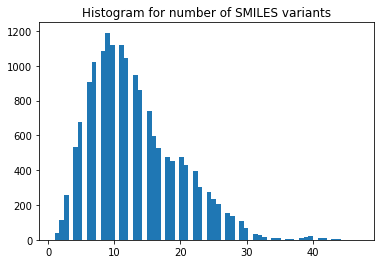

CPU times: user 26 s, sys: 181 ms, total: 26.2 s
Wall time: 26.3 s


In [10]:
%%time

# N-gram library in XenonPy-iQSPR
from xenonpy.inverse.iqspr import NGram

np.random.seed(201906) # fix the random seed

# Method 2: expand n-gram training set with randomly reordered SMILES
# (we show one of the many possible ways of doing it)
n_reorder = 15 # pick a fixed number of re-ordering

# convert the SMILES to canonical SMILES in RDKit (not necessary in general)
cans = []
for smi in data['SMILES']:
    # remove some molecules in the full SMILES list that may lead to error
    try:
        cans.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
    except:
        print(smi)
        pass

mols = [Chem.MolFromSmiles(smi) for smi in cans]
smi_reorder_all = []
smi_reorder = []
for mol in mols:
    idx = list(range(mol.GetNumAtoms()))
    tmp = [Chem.MolToSmiles(mol,rootedAtAtom=x) for x in range(len(idx))]
    smi_reorder_all.append(np.array(list(set(tmp))))
    smi_reorder.append(np.random.choice(smi_reorder_all[-1],n_reorder,
                                        replace=(len(smi_reorder_all[-1]) < n_reorder)))

n_uni = [len(x) for x in smi_reorder_all]
plt.hist(n_uni, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for number of SMILES variants")
plt.show()


In [11]:
%%time

# flatten out the list and train the N-gram
flat_list = [item for sublist in smi_reorder for item in sublist]

# first train up to order 10
n_gram_reorder1 = NGram(reorder_prob=0.5)
n_gram_reorder1.fit(flat_list,train_order=10)
# save results
with open('ngram_pubchem_ikebata_reO15_O10.obj', 'wb') as f:
    pk.dump(n_gram_reorder1, f)
    
# Then, train up from order 11 to 20
n_gram_reorder2 = NGram(reorder_prob=0.5)
n_gram_reorder2.fit(flat_list,train_order=(11, 20))
# save results
with open('ngram_pubchem_ikebata_reO15_O11to20.obj', 'wb') as f:
    pk.dump(n_gram_reorder2, f)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 250095/250095 [7:24:45<00:00,  9.37it/s]   
/Users/stephenwu/anaconda3/envs/xepy_beta_20190924/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:124: RuntimeWarning: min <sample_order>: 1 is smaller than min <train_order>: 11,min <sample_order> will be increased to min <train_order>
  RuntimeWarning)
/Users/stephenwu/anaconda3/envs/xepy_beta_20190924/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:132: RuntimeWarning: min <sample_order>: 11 is greater than min_len: 1,min_len will be increased to min <sample_order>
  RuntimeWarning)
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 250095/250095 [29:11:18<00:00,  2.38it/s]    


Here, we will load the two parts of the pre-trained `NGram` files and combine them for our use in the example. Note that you have the option to overwrite an existing `NGram` while combining or create a new one. We recommend overwriting the existing one (default setting of merge_table) if the `NGram` table is expected to be very large in order to avoid memory issue.

In [28]:
# load a pre-trained n-gram from the pickle file
with open('ngram_pubchem_ikebata_reO15_O10.obj', 'rb') as f:
    n_gram = pk.load(f)
    
# load a pre-trained n-gram from the pickle file
with open('ngram_pubchem_ikebata_reO15_O11to20.obj', 'rb') as f:
    n_gram2 = pk.load(f)

n_gram.merge_table(n_gram2)

NGram(del_range=(1, 10), max_len=1000, min_len=1, ngram_tab=None,
      reorder_prob=0.5, sample_order=(1, 10))

### iQSPR: sequential Monte Carlo

After the preparation of forward model (likelihood) and `NGram` model (prior), we are now ready to perform the actual iteration of iQSPR to generate molecules in our target property region.

##### run iQSPR

We need to first set up some initial molecules as a starting point of our iQSPR iteration. Note that the number of molecules in this initial set governs the number of molecules generated in each iteration step. In practice, you may want at least 100 or even 1000 molecules per step depending your computing resources to avoid getting trapped in a local region when searching the whole molecular space defined by your N-gram model.

In [29]:
# set up initial molecules for iQSPR
np.random.seed(201906) # fix the random seed
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for i, smi in enumerate(data_ss['SMILES'])
       if (data_ss['HOMO-LUMO gap'].iloc[i] > 4)]
init_samples = np.random.choice(cans, 25)
print(init_samples)


['CC(Cc1ccccc1)NCCn1cnc2c1c(=O)n(C)c(=O)n2C' 'CN1CCN(C)C1=O' 'N#CO'
 'COC1C(O)C(N)C(OC2OC(C(C)N)CCC2N)C(O)C1N(C)C(=O)CN' 'CCCCOP(N)(=O)OCCCC'
 'NS(=O)(=O)Cl' 'CCSC(=O)N(CC)CC' 'CCCCCC=CCC=CCC=CCCCCC(=O)O'
 'CCCCCC=CCC=CCC=CC=CC(O)CCCC(=O)O'
 'CC1NCCc2c(C(=O)N3CCCCC3)[nH]c3cccc1c23' 'ClC1C=CC(Cl)C(Cl)C1Cl'
 'CC1=CC(=O)CC1' 'CC1C(=O)NC(=O)N(C2CCCCC2)C1=O'
 'O=[N+]([O-])c1cc2nc(C(F)(F)F)[nH]c2cc1Cl' 'O=C1C=C2NC(C(=O)O)C=C2CC1=O'
 'CCSC(=O)N(CC)CC' 'CCCCCCCCOc1ccc(C(=O)c2ccccc2O)c(O)c1'
 'COc1ccc2c(c1)CCC(c1ccccc1)C2(O)c1ccccn1'
 'CCN(CCOC(=O)C(OC)(c1ccccc1)c1ccccc1)CC(C)C' 'COc1ccccc1NC(=O)CC(C)=O'
 'CC1CC2C(=CC1=O)CCC1C2CCC2(C)C1CCC2(C)O' 'C1COCCN1' 'NCCNCCO'
 'CCC(C)Cc1cccc(O)c1C' 'COC(F)(F)CCl']


For any sequential Monte Carlo algorithm, annealing is usually recommended to avoid getting trapped in a local mode. In iQSPR, we use the beta vector to control our annealing schedule. We recommend starting with a small number close to 0 to minimize the influence from the likelihood at the beginning steps and using some kind of exponential-like schedule to increase the beta value to 1, which represents the state of the original likelihood. The length of the beta vector directly controls the number of iteration in iQSPR. We recommend adding more steps with beta=1 at the end to allow exploration of the posterior distribution (your target property region). In practice, iteration of the order of 100 or 1000 steps is recommended depending your computing resources.

In [65]:
# set up annealing schedule in iQSPR
beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)


Number of steps: 50
[0.01       0.02       0.03       0.04       0.05       0.06
 0.07       0.08       0.09       0.1        0.11       0.12
 0.13       0.14       0.15       0.16       0.17       0.18
 0.19       0.2        0.21       0.23111111 0.25222222 0.27333333
 0.29444444 0.31555556 0.33666667 0.35777778 0.37888889 0.4
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


**<span style="color: red; ">Warning: the next module may take 2-3min to complete!</span>**

Putting together the initial molecules, beta vector, forward model (likelihood), N-gram model (prior), you can now use a for-loop over the IQSPR class to get the generated molecules at each iteration step. More information can be extracted from the loop by setting "yield_lpf" to True (l: log-likelihood, p: probability of resampling, f: frequency of appearence). Note that the length of generated molecules in each step may not equal to the length of intial molecules because we only track the unique molecules and record their appearance frequency separately.

We will use the previously trained `NGram` here. Please make sure you have loaded the `NGram` models and merged them property in the previous section. We will reset the parameters again to make sure the values are what we expected them to be. 

Note that warnings will be thrown out if there are molecules generated from the `NGram` that cannot be converted to RDKit's MOL format. 

In [31]:
%%time

# library for running iQSPR in XenonPy-iQSPR
from xenonpy.inverse.iqspr import IQSPR

# update NGram parameters for this exampleHOMO-LUMO gap
n_gram.set_params(del_range=[1,20],max_len=500, reorder_prob=0.5, sample_order=(1,20))

# set up likelihood and n-gram models in iQSPR
iqspr_reorder = IQSPR(estimator=prd_mdls, modifier=n_gram)
    
np.random.seed(201906) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open('iQSPR_results_reorder.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)


/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c1cc(CCNc2ccc(N=Nc3ccc(OC)c(N=Nc4ccc(N)cc4)c3C2=O)c2c1C(=O)c1ccccc1C2=O)CC to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c12c3ccc4cccc(ccc1cc([N+](=O)[O-])c3)-c3cccc(cc4)c32 to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c1cc(N=Nc2ccccc(C)c2)cc(Cl)c1C(=O)OC1CCN(C)CC1 to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert Nc1c(S(=O)(=O)O)cc(Nc2c

CPU times: user 2min 42s, sys: 11 s, total: 2min 53s
Wall time: 3min 9s


##### plot results

Let us take a look at the results.

In [58]:
with open('iQSPR_results_reorder.obj', 'rb') as f:
    iqspr_results_reorder = pk.load(f)
    

First, we look at how the likelihood values of the generated molecules converged to a distribution peaked around 1 (hitting the target property region). The gradient correlates well to the annealing schedule.

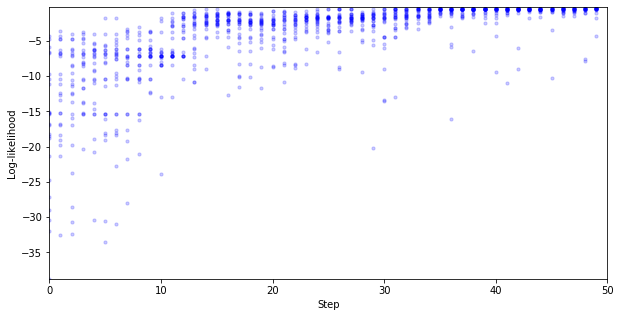

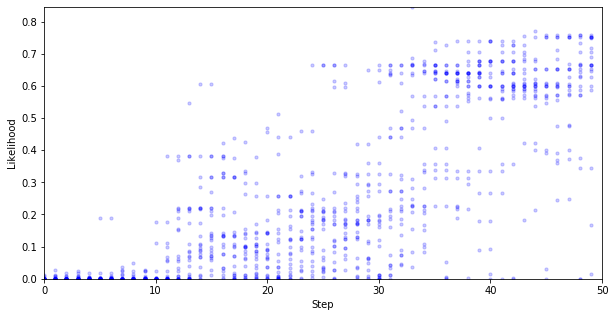

In [59]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()


**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

Next, we plot the evolution of the generated molecules in the target property space.

In [60]:
%%time

# re-calculate the property values for the proposed molecules
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    tmp_fps = RDKit_FPs.transform(smis)
    FPs_samples.append(tmp_fps)
    
    tmp1, tmp2 = prd_mdls["E"].predict(tmp_fps)
    x_mean.append(tmp1)
    x_std.append(tmp2)
    
    tmp1, tmp2 = prd_mdls["HOMO-LUMO gap"].predict(tmp_fps)
    y_mean.append(tmp1)
    y_std.append(tmp2)
    
    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))


Range of std. dev.: (25.5277,40.3270)
CPU times: user 15.6 s, sys: 7.93 s, total: 23.5 s
Wall time: 38.2 s


**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

In [66]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_prd/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["E"],
    np.asarray([item for sublist in x_mean for item in sublist])))
x_max, x_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["HOMO-LUMO gap"],
    np.asarray([item for sublist in y_mean for item in sublist])))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = iqspr_results_reorder["beta"]

for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5
    
    plt.figure(figsize=(5,5))
    rectangle = plt.Rectangle((0,0),200,3,fc='y',alpha=0.1)
    plt.gca().add_patch(rectangle)
    plt.scatter(data_ss["E"], data_ss["HOMO-LUMO gap"],s=3, c='b', alpha=0.2)
    plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.5)
    plt.title('Step: %i (beta = %.3f)' % (i,tmp_beta[i]))
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.xlabel('Internal energy')
    plt.ylabel('HOMO-LUMO gap')
    #plt.show()
    plt.savefig(ini_dir+'Step_%02i.png' % i,dpi = 500)
    plt.close()


CPU times: user 27.9 s, sys: 736 ms, total: 28.6 s
Wall time: 32.6 s


**<span style="color: red; ">Warning: the next module may take 10-15min to complete!</span>**

Finally, let us take a look at the generated molecular structures.

In [46]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_smiles/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]    

n_S = 25
for i, smis in enumerate(iqspr_results_reorder['samples']):
    tmp_smis = iqspr_results_reorder['samples'][i][
        np.argsort(tmp_list[i])[::-1]]
    fig, ax = plt.subplots(5, 5)
    fig.set_size_inches(20, 20)
    fig.set_tight_layout(True)
    for j in range(n_S):
        xaxis = j // 5
        yaxis = j % 5
        try:
            img = Draw.MolToImage(Chem.MolFromSmiles(tmp_smis[j]))
            ax[xaxis, yaxis].clear()
            ax[xaxis, yaxis].set_frame_on(False)
            ax[xaxis, yaxis].imshow(img)
        except:
            pass
        ax[xaxis, yaxis].set_axis_off()
    fig.savefig(ini_dir+'Step_%02i.png' % i,dpi = 500)
    plt.close()
    

CPU times: user 6min 54s, sys: 18 s, total: 7min 12s
Wall time: 7min 25s


We can now compare our generated molecules with the 16 existing molecules in our data set that are in the target region. You can see that our generated molecules contain substructures that are similar to a few of the existing molecules.

In [41]:
target_smis = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for i, smi in enumerate(data_ss['SMILES'])
       if ((data_ss['HOMO-LUMO gap'].iloc[i] <= 3) and (data_ss['E'].iloc[i] <= 200))]

In [42]:
print(target_smis)

['O=C1N=c2cc([N+](=O)[O-])c([N+](=O)[O-])cc2=NC1=O', 'O=C1C(O)=C(c2ccccc2)C(=O)C(O)=C1c1ccccc1', 'O=c1ccc2[n+]([O-])c3ccc(O)cc3oc-2c1', 'Nc1ccc2nc3ccccc3nc2c1N', 'Cc1cc(Cl)cc2c1C(=O)C(=C1Sc3cc(Cl)cc(C)c3C1=O)S2', 'Nc1ccc(N)c2c1C(=O)c1c(N)ccc(N)c1C2=O', 'COc1cc(N)c2c(c1N)C(=O)c1ccccc1C2=O', 'Nc1ccc(O)c2c1C(=O)c1ccccc1C2=O', 'CNc1ccc(N(CCO)CCO)cc1[N+](=O)[O-]', 'C1=Cc2c3ccccc3cc3c4c(cc1c23)=CCCC=4', 'O=C(CN1CCOCC1)NN=Cc1ccc([N+](=O)[O-])o1', 'CNc1ccc(O)c2c1C(=O)c1c(O)ccc(NC)c1C2=O', 'O=C1c2c(O)ccc(O)c2C(=O)c2c(O)ccc(O)c21', 'O=C1C=CC(=C2C=CC(=O)C=C2)C=C1', 'c1ccc2c(c1)ccc1c2ccc2ccc3ccccc3c21', 'NC1=NC(=O)C2=C(CNC3C=CC(O)C3O)C=NC2=N1']


In [43]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_target_smiles/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

n_S = 25

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(20, 20)
fig.set_tight_layout(True)
for j in range(n_S):
    xaxis = j // 5
    yaxis = j % 5
    try:
        img = Draw.MolToImage(Chem.MolFromSmiles(target_smis[j]))
        ax[xaxis, yaxis].clear()
        ax[xaxis, yaxis].set_frame_on(False)
        ax[xaxis, yaxis].imshow(img)
    except:
        pass
    ax[xaxis, yaxis].set_axis_off()
fig.savefig(ini_dir+'target_region.png',dpi = 500)
plt.close()

CPU times: user 7.46 s, sys: 355 ms, total: 7.82 s
Wall time: 8.18 s


##### run iQSPR with different annealing schedules

In some cases, you may want to give priority to certain property reaching the target region. This can be done by adjusting the annealing schedule for each property. To do so, you can input a dictionary for beta, instead. Here, we try to reach a low value for internal energy first. Hence, the annealing schedule for HOMO-LUMO gap has a longer flat region.

In [67]:
# set up annealing schedule in iQSPR
beta1 = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
beta2 = np.hstack([np.linspace(0.2/35,0.2,35),np.linspace(0.21,0.4,5),np.linspace(0.4,1,5),np.linspace(1,1,5)])
beta = pd.DataFrame({'E': beta1, 'HOMO-LUMO gap': beta2})
print(beta)

           E  HOMO-LUMO gap
0   0.010000       0.005714
1   0.020000       0.011429
2   0.030000       0.017143
3   0.040000       0.022857
4   0.050000       0.028571
5   0.060000       0.034286
6   0.070000       0.040000
7   0.080000       0.045714
8   0.090000       0.051429
9   0.100000       0.057143
10  0.110000       0.062857
11  0.120000       0.068571
12  0.130000       0.074286
13  0.140000       0.080000
14  0.150000       0.085714
15  0.160000       0.091429
16  0.170000       0.097143
17  0.180000       0.102857
18  0.190000       0.108571
19  0.200000       0.114286
20  0.210000       0.120000
21  0.231111       0.125714
22  0.252222       0.131429
23  0.273333       0.137143
24  0.294444       0.142857
25  0.315556       0.148571
26  0.336667       0.154286
27  0.357778       0.160000
28  0.378889       0.165714
29  0.400000       0.171429
30  0.400000       0.177143
31  0.466667       0.182857
32  0.533333       0.188571
33  0.600000       0.194286
34  0.666667       0

Let us try to re-run the IQSPR to see how the results may differ

In [73]:
%%time

# library for running iQSPR in XenonPy-iQSPR
from xenonpy.inverse.iqspr import IQSPR

# update NGram parameters for this exampleHOMO-LUMO gap
n_gram.set_params(del_range=[1,20],max_len=500, reorder_prob=0.5)

# set up likelihood and n-gram models in iQSPR
iqspr_reorder = IQSPR(estimator=prd_mdls, modifier=n_gram)
    
np.random.seed(201909) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open('iQSPR_results_reorder2.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)


/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert C1CCN(C(=O)c2[nH]c3c(Cl)ccc4c3c1-c1ccccc1C4)CC2 to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c12cccc3c1c(c(C(=O)c1c(C)cc(CC(=O)O)no1)[nH]2)CC2C3=CC(NC(=O)N(CC)CC)CN2C to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c1cccc2c(C(=O)C(=O)NC=Cc3c4ccc(N)cc4)c(C)n1c23 to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
/Users/stephenwu/anaconda/envs/xepy37_test/lib/python3.7/site-packages/xenonpy/inverse/iqspr/modifier.py:527: RuntimeWarning: can not convert c1(Br)ccc2c(C=CNC(=O)C(=O)c3c

CPU times: user 2min 36s, sys: 11.7 s, total: 2min 48s
Wall time: 3min


##### plot results

Let us take a look at the results.

In [74]:
with open('iQSPR_results_reorder2.obj', 'rb') as f:
    iqspr_results_reorder = pk.load(f)
    

First, we look at how the likelihood values of the generated molecules converged to a distribution peaked around 1 (hitting the target property region). The gradient correlates well to the annealing schedule.

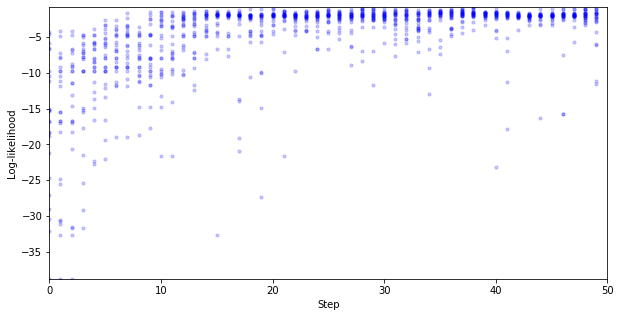

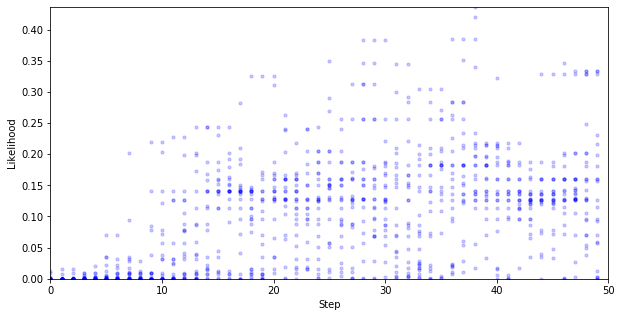

In [75]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()


**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

Next, we plot the evolution of the generated molecules in the target property space.

In [76]:
%%time

# re-calculate the property values for the proposed molecules
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    tmp_fps = RDKit_FPs.transform(smis)
    FPs_samples.append(tmp_fps)
    
    tmp1, tmp2 = prd_mdls["E"].predict(tmp_fps)
    x_mean.append(tmp1)
    x_std.append(tmp2)
    
    tmp1, tmp2 = prd_mdls["HOMO-LUMO gap"].predict(tmp_fps)
    y_mean.append(tmp1)
    y_std.append(tmp2)
    
    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))


Range of std. dev.: (25.5185,34.6501)
CPU times: user 10.5 s, sys: 5.14 s, total: 15.6 s
Wall time: 26.4 s


**<span style="color: red; ">Warning: the next module may take 1-2min to complete!</span>**

We can see that the algorithm spent a longer time exploring the lower internal energy region, which ends up not able to find candidates within our target region in this particular test case. In practice, a certain direction may be preferred to guide the search based on prior knowledge.

In [77]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_prd2/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["E"],
    np.asarray([item for sublist in x_mean for item in sublist])))
x_max, x_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["HOMO-LUMO gap"],
    np.asarray([item for sublist in y_mean for item in sublist])))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = iqspr_results_reorder["beta"]

for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5
    
    plt.figure(figsize=(5,5))
    rectangle = plt.Rectangle((0,0),200,3,fc='y',alpha=0.1)
    plt.gca().add_patch(rectangle)
    plt.scatter(data_ss["E"], data_ss["HOMO-LUMO gap"],s=3, c='b', alpha=0.2)
    plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.5)
    plt.title('Step: %i (beta = %.3f, %.3f)' % (i,tmp_beta.iloc[i,0],tmp_beta.iloc[i,1]))
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.xlabel('Internal energy')
    plt.ylabel('HOMO-LUMO gap')
    #plt.show()
    plt.savefig(ini_dir+'Step_%02i.png' % i,dpi = 500)
    plt.close()


CPU times: user 23.7 s, sys: 444 ms, total: 24.2 s
Wall time: 24.3 s


Thank you for using XenonPy-iQSPR. We would appreciate any feedback and code contribution to this open-source project.

The sample code can be downloaded at:
https://github.com/yoshida-lab/XenonPy/blob/master/samples/iQSPR.ipynb